## Image Simulations

This notebook is a tutorial on **image simulation** for our galaxy image dataset. In our project, it is crucial that we properly generate a dataset comprised of blurred galaxy images (input) and non-blurred galaxy images (ground truth) to train and test the unrolled ADMM model. We used the modular galaxy image simulation toolkit [Galsim](https://github.com/GalSim-developers/GalSim) and the [COSMOS Real Galaxy Dataset](https://zenodo.org/record/3242143#.Ytjzki-KFAY) for our simulations. 

Our forward model is desciribed by the following equation. The distant galaxy $\mathbf{G}$ is sheared and convolved with the effective point spread function $\mathbf{PSF}$. Poisson shot noise and Gaussian read noise $\mathbf{N_r}$ are added to obtain the observed galaxy $\mathbf{\tilde{G}}$.

$\begin{equation} \mathbf{\tilde{G}} = \text{Poisson}(\text{shear}(\mathbf{G}) \otimes \mathbf{PSF}) + \mathbf{N_r} \end{equation}$

To simulate images from a typical **ground-based** sky survey, we used the parameters of the [**Vera C. Rubin Observatory (LSST)**](https://www.lsst.org) and parameters from the **GREAT3 Challenge**.

First, we import the packages we need. We use Galsim to load and process COSMOS data. We use PyTorch to do convolution and add noise since our deconvolution method is implemented with PyTorch. Galsim could be downloaded with pip:
```zsh
pip install Galsim
```

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.fft import fft2, ifft2, fftshift, ifftshift
import galsim

/home/tianaoli/.conda/envs/astro/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Fundamental Parameters

These parameters determines the size and resolution of simulated images.

In [2]:
fov_pixels = 48                     # Number of pixels in FOV, the size of the image is (fov_pixels, fov_pixels).
pixel_scale = 0.2                   # Pixel scale (aresec), determines the resolution (0.2 for LSST).
upsample = 4                        # Upsample factor for the images.

These parameters on CCD and sky brightness determines the sky level in the image. Since the COSMOS data are taken with HST [F814W](https://hst-docs.stsci.edu/wfc3ihb/appendix-a-wfc3-filter-throughputs/a-2-throughputs-and-signal-to-noise-ratio-data/uvis-f814w) filter, the passband overlaps the most with LSST i band. Therefore we use the zero point and sky brightness for LSST i band. LSST's zero point, sky brightness, gain and exposure time can be found [here](https://smtn-002.lsst.io/#instrumental-noise). The quantum efficiency can be found [here](https://zenodo.org/record/44810#.Y8ih_S-KFhE).

In [3]:
exp_time = 30.                      # Exposure time (2*15 seconds).
sky_brightness = 20.48              # Sky brightness (absolute magnitude) in i band.
zero_point = 27.85                  # Instrumental zero point, i.e. absolute magnitude that would produce one e- per second.
gain = 2.3                          # CCD Gain (e-/ADU).
qe = 0.94                           # CCD Quantum efficiency.
read_noise = 8.8                    # Standrad deviation of Gaussain read noise (e-/pixel).

### Calculate Sky Level

In [4]:
def get_flux(ab_magnitude, exp_time, zero_point, gain, qe):
    """Calculate flux (ADU/arcsec^2) from magnitude.

    Args:
        ab_magnitude (`float`): Absolute magnitude.
        exp_time (`float`): Exposure time (s).
        zero_point (`float`): Instrumental zero point, i.e. absolute magnitude that would produce one e- per second.
        gain (`float`): CCD Gain (e-/ADU).
        qe (`float`): CCD Quantum efficiency.

    Returns:
        `float`: (Flux ADU/arcsec^2).
    """
    return exp_time * zero_point * 10**(-0.4*(ab_magnitude-24)) * qe / gain

sky_level_pixel = get_flux(ab_magnitude=sky_brightness, exp_time=exp_time, zero_point=zero_point, gain=gain, qe=qe) * pixel_scale ** 2
print('sky_level_pixel: {:.4g}'.format(sky_level_pixel))

sky_level_pixel: 349.5


### Read out galaxies from COSMOS Real Galaxy Catalog

Download the [COSMOS Real Galaxy Dataset](https://zenodo.org/record/3242143#.Ytjzki-KFAY) from Zenodo or using the following command:
```zsh
galsim_download_cosmos -s 23.5
```
Initialize the RealGalaxyCatalog and read out a galaxy with an index. Take a look at the original images and you'll notice it has a pretty high resolution. This is because the Hubble Space Telescope has a pixel scale of 0.05 arcsec. We used ~56,000 galaxies in the COSMOS F814W<23.5 training sample in our simulated dataset.

Text(0.5, 1.0, 'Galaxy')

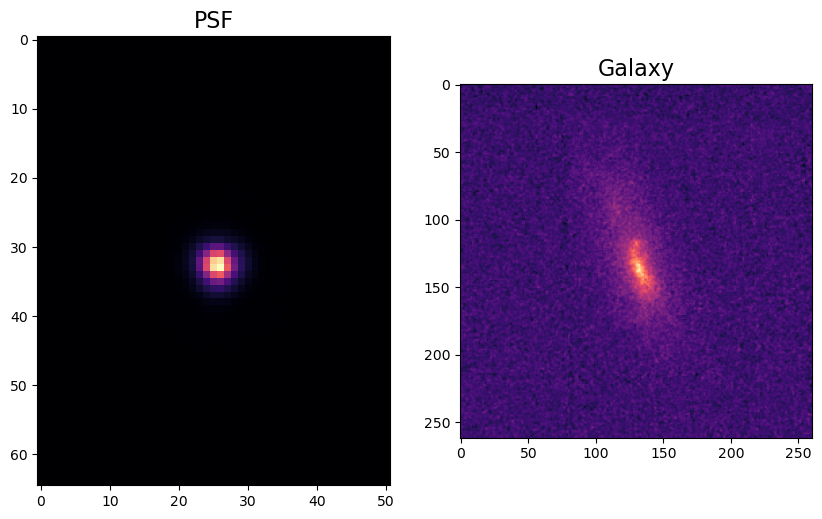

In [5]:
# Initialize catalog
COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample' # path to your COSMOS data.
# real_galaxy_catalog = galsim.RealGalaxyCatalog(sample="23.5")
real_galaxy_catalog = galsim.RealGalaxyCatalog(file_name=os.path.join(COSMOS_dir, 'real_galaxy_catalog_23.5.fits'))

# Pick a galaxy
gal_idx = 245 # Galaxy index in the catalog
gal_ori = galsim.RealGalaxy(real_galaxy_catalog, index=gal_idx)
psf_hst = real_galaxy_catalog.getPSF(gal_idx)
gal_ori_image = real_galaxy_catalog.getGalImage(gal_idx)
psf_ori_image = real_galaxy_catalog.getPSFImage(gal_idx)

cmap = 'magma' # Color map for pyplot visualization

# Visulaize galaxy & PSF in COSMOS data
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(psf_ori_image.array, cmap=cmap)
plt.title('PSF', fontsize=16)
plt.subplot(1,2,2)
plt.imshow(gal_ori_image.array, cmap=cmap) 
plt.title('Galaxy', fontsize=16)

### Simulate Point Spread Function

**Point Spread Functions (PSF)** is the most crucial component in our image simulation. In our imaging forward model, we assume that the PSF consists of two components caused by the atmospheric turbulence and the telescope optics to approximate a typical ground-based obseravtion. The overall PSF is the convolution of the two components:
$\begin{equation} PSF = PSF_{atmos} \otimes PSF_{optical} \end{equation}$

To include randomness in our simulation, we use random number generators (RNG) provided by Galsim. All parameters are sampled from a proper distribution. We first set up the RNGs needed.

In [6]:
random_seed = 31416
rng_base = galsim.BaseDeviate(seed=random_seed)
rng = galsim.UniformDeviate(seed=random_seed) # U(0,1).
rng_defocus = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.36) # N(0,0.36).
rng_gaussian = galsim.GaussianDeviate(rng_base, mean=0., sigma=0.07) # N(0,0.07).

The distribution of the atmospheric seeing, namely the FWHM of the atmospheric PSF, is an approximated distribution used in GREAT3 simulations.

Text(0.5, 1.0, 'FWHM Distribution of Atmospheric PSF')

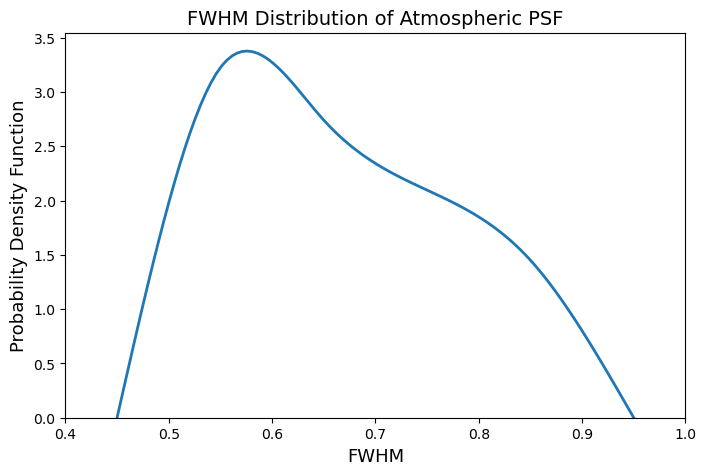

In [7]:
# The FWHM of the PSF, namely the atmospheric seeing.
fwhms = np.array([0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
freqs = np.array([0., 20., 17., 13., 9., 0.])
fwhm_table = galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline')
fwhms = np.linspace(fwhms[0],fwhms[-1],100) # Upsample the distribution.
freqs = np.array([fwhm_table(fwhm) for fwhm in fwhms]) / fwhm_table.integrate() # Normalization.
rng_fwhm = galsim.DistDeviate(seed=rng_base, function=galsim.LookupTable(x=fwhms, f=freqs, interpolant='spline'))

# Plot the Distribution of FWHM.
plt.figure(figsize=(8,5))
plt.plot(fwhms, freqs, linewidth=2)
plt.xlim(0.4,1)
plt.ylim(0)
plt.xlabel('FWHM', fontsize=13)
plt.ylabel('Probability Density Function', fontsize=13)
plt.title('FWHM Distribution of Atmospheric PSF', fontsize=14)

Now we sample PSF parameters using RNGs.

In [8]:
# Atmospheric PSF
atmos_fwhm = rng_fwhm()             # Atmospheric seeing (arcsec), the FWHM of the Kolmogorov function.
atmos_e = 0.01 + 0.02 * rng()       # Ellipticity of atmospheric PSF (magnitude of the shear in the “distortion” definition), U(0.01, 0.03).
atmos_beta = 2. * np.pi * rng()     # Shear position angle (radians), N(0,2*pi).

# Optical PSF
opt_defocus = rng_defocus()         # Defocus (wavelength), N(0.0.36).
opt_a1 = rng_gaussian()             # Astigmatism (like e2) (wavelength), N(0.0.07).
opt_a2 = rng_gaussian()             # Astigmatism (like e1) (wavelength), N(0.0.07).
opt_c1 = rng_gaussian()             # Coma along y axis (wavelength), N(0.0.07).
opt_c2 = rng_gaussian()             # Coma along x axis (wavelength), N(0.0.07).
spher = rng_gaussian()              # Spherical aberration (wavelength), N(0.0.07).
trefoil1 = rng_gaussian()           # Trefoil along y axis (wavelength), N(0.0.07).
trefoil2 = rng_gaussian()           # Trefoil along x axis (wavelength), N(0.0.07).
opt_obscuration = 0.1 + 0.4 * rng() # Linear dimension of central obscuration as fraction of pupil linear dimension, U(0.1, 0.5).
lam_over_diam = .017 + 0.007 * rng() # Wavelength over diameter (arcsec), U(0.013, 0.083).

Now we can simulate the two PSF components respectively and convolve them together. We used the Kolmogorov function to simulate the atmospheric component while the optical component is an aberrated PSF caused by telescope optics. The flux of the PSFs are all 1.

In [9]:
# Atmospheric PSF
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1)
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)

# Optical PSF
optics = galsim.OpticalPSF(lam_over_diam,
                           defocus = opt_defocus,
                           coma1 = opt_c1, coma2 = opt_c2,
                           astig1 = opt_a1, astig2 = opt_a2,
                           spher=spher, trefoil1=trefoil1, trefoil2=trefoil2,
                           obscuration = opt_obscuration,
                           flux=1)

# Convolve the two components
psf = galsim.Convolve([atmos, optics])

# Draw PSF images
optics_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
optics.drawImage(optics_psf_image, scale=pixel_scale/upsample, method='auto')
atmos_psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
atmos.drawImage(atmos_psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
psf.drawImage(psf_image, scale=pixel_scale/upsample, method='auto')
psf_image = torch.from_numpy(psf_image.array)
# psf_image = torch.max(torch.zeros_like(psf_image), psf_image)

Now we visualize the simulated PSF and its two components.

Text(0.5, 1.0, 'Atmospheric PSF')

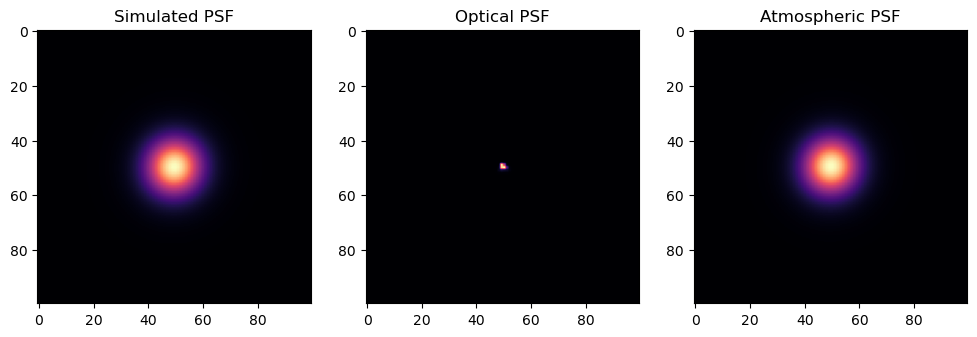

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(psf_image[46:-46,46:-46], cmap=cmap)
plt.title('Simulated PSF')

plt.subplot(1,3,2)
plt.imshow(optics_psf_image.array[46:-46,46:-46], cmap=cmap)
plt.title('Optical PSF')

plt.subplot(1,3,3)
plt.imshow(atmos_psf_image.array[46:-46,46:-46], cmap=cmap)
plt.title('Atmospheric PSF')

### Simulate Observed Galaxy

Similarly, we sample galaxy parameters from distributions first.

In [11]:
rng_gal_shear = galsim.DistDeviate(seed=rng, function=lambda x: x, x_min=0.01, x_max=0.05)

gal_g = rng_gal_shear()             # Shear of the galaxy (magnitude of the shear in the "reduced shear" definition), U(0.01, 0.05).
gal_beta = 2. * np.pi * rng()       # Shear position angle (radians), N(0,2*pi).
gal_mu = 1 + rng() * 0.1            # Magnification, U(1.,1.1).
theta = 2. * np.pi * rng()          # Rotation angle (radians), U(0,2*pi).
dx = 2 * rng() - 1                  # Offset along x axis, U(-1,1).
dy = 2 * rng() - 1                  # Offset along y axis, U(-1,1).

Then, we initialize a RealGalaxy object with the real galaxy. Here we are using the ```COSMOSCatalog``` (not the ```RealGalaxyCatalog``` used at the beginning). This is because we want to get the parametric model of the galaxy, since we do not have noise-free images for the real galaxies (for SNR calculation). We can use the model fits to the galaxy images as noise-free images for this purpose.

In [12]:
# cosmos_catalog = galsim.COSMOSCatalog(sample='23.5', use_real=True)
# print(cosmos_catalog.nobjects)
# gal_ori = cosmos_catalog.makeGalaxy(idx_gal, gal_type='parametric', sersic_prec=0.) # Use parametric model

Now we randomly rotate, shear and magnify the galaxy to simulated a real galaxy distorted by weak lensing effects. 

In [13]:
gal = gal_ori.rotate(theta * galsim.radians) # Rotate by a random angle
gal = gal.shear(g=gal_g, beta=gal_beta * galsim.radians) # Apply the desired shear
gal = gal.magnify(gal_mu) # Apply a magnification

# Draw galaxy image
gal = galsim.Convolve([psf_hst, gal]) # Convolve wth original PSF of HST to avoid FFT error.
gal_image = galsim.ImageF(upsample*fov_pixels, upsample*fov_pixels)
gal.drawImage(gal_image, scale=pixel_scale/upsample, offset=(dx,dy), method='auto')
gal_image = torch.from_numpy(gal_image.array)

Now we scale the flux of the galaxy according to given SNRs. We used the same SNR defination as the [GREAT3 Challenge](https://iopscience.iop.org/article/10.1088/0067-0049/212/1/5/meta). The variance $V$ at each pixel is treated to be the same, because the the sky level is often high enough that its Poisson noise is essentially Gaussian corresponding to a single constant variance and a mean of zero. However, we still use Poisson noise in our simulations but keep the constant variance approximation in our SNR calculations. So the variance at each pixel $V$ is the sum of Poisson shot noise $I_0$, which is also the sky level, and that of the Gaussian read noise $\sigma^2$.

$\begin{equation}
SNR = \sqrt{\frac{\Sigma G(x,y)^2}{V}} = \sqrt{\frac{\Sigma G(x,y)^2}{I_0 + \sigma^2}}
\end{equation}$

In [14]:
def down_sample(input, rate=4):
    """Downsample the input image using an average filter."""
    weight = torch.ones([1,1,rate,rate]) / (rate**2) # Average filter.
    input = input.unsqueeze(0).unsqueeze(0)
    output = F.conv2d(input=input, weight=weight, stride=rate).squeeze(0).squeeze(0)
    return output

gal_image_down = down_sample(gal_image, rate=upsample)

Now we scale the galaxy with desired SNR.

In [15]:
snr_list = [20, 50, 100, 200, 300]
gt_list = []

sigma = np.sqrt(sky_level_pixel + 2 * (read_noise*qe/gain) ** 2)
print('sigma: {:.4g}'.format(sigma))
for snr in snr_list:
    alpha = snr * sigma / torch.sqrt((gal_image_down**2).sum()) # Scale the flux of galaxy to meet SNR requirement.
    gt_list.append(gal_image * alpha)

sigma: 19.37


And then convolve the galaxy with the PSF using FFT to simulate blurred image.

In [16]:
conv_list = []
for i, gt in enumerate(gt_list):
    conv = fftshift(ifft2(fft2(ifftshift(psf_image)) * fft2(ifftshift(gt)))).real # Convolution using FFT.
    conv = down_sample(conv)
    # conv = torch.max(torch.zeros_like(conv), conv) # Set negative pixels to zero.
    conv_list.append(conv)
    gt_list[i] = down_sample(gt)

Finally we add CCD noise to get an observed image. We use gaussian noise to approxiamte Poisson shot noise since the counts are high enough for the Poisson distribution to be treated as Gaussian.

In [17]:
obs_list = []
for conv in conv_list:
    obs = conv + torch.normal(mean=torch.zeros_like(conv), std=sigma*torch.ones_like(conv))
    # obs = torch.max(torch.zeros_like(obs), obs) # Set negative pixels to zero.
    obs_list.append(obs)

The PSF used in deconvolution should also be downsampled to the same pixel scale.

In [18]:
psf_image_down = down_sample(psf_image)

### Plot Images

Finally we can visualize our simulated galaxy. The histograms of the simulated images are also plotted, where vertical red dashed lines represents the sky level. The pixel values are centered at sky level and variance

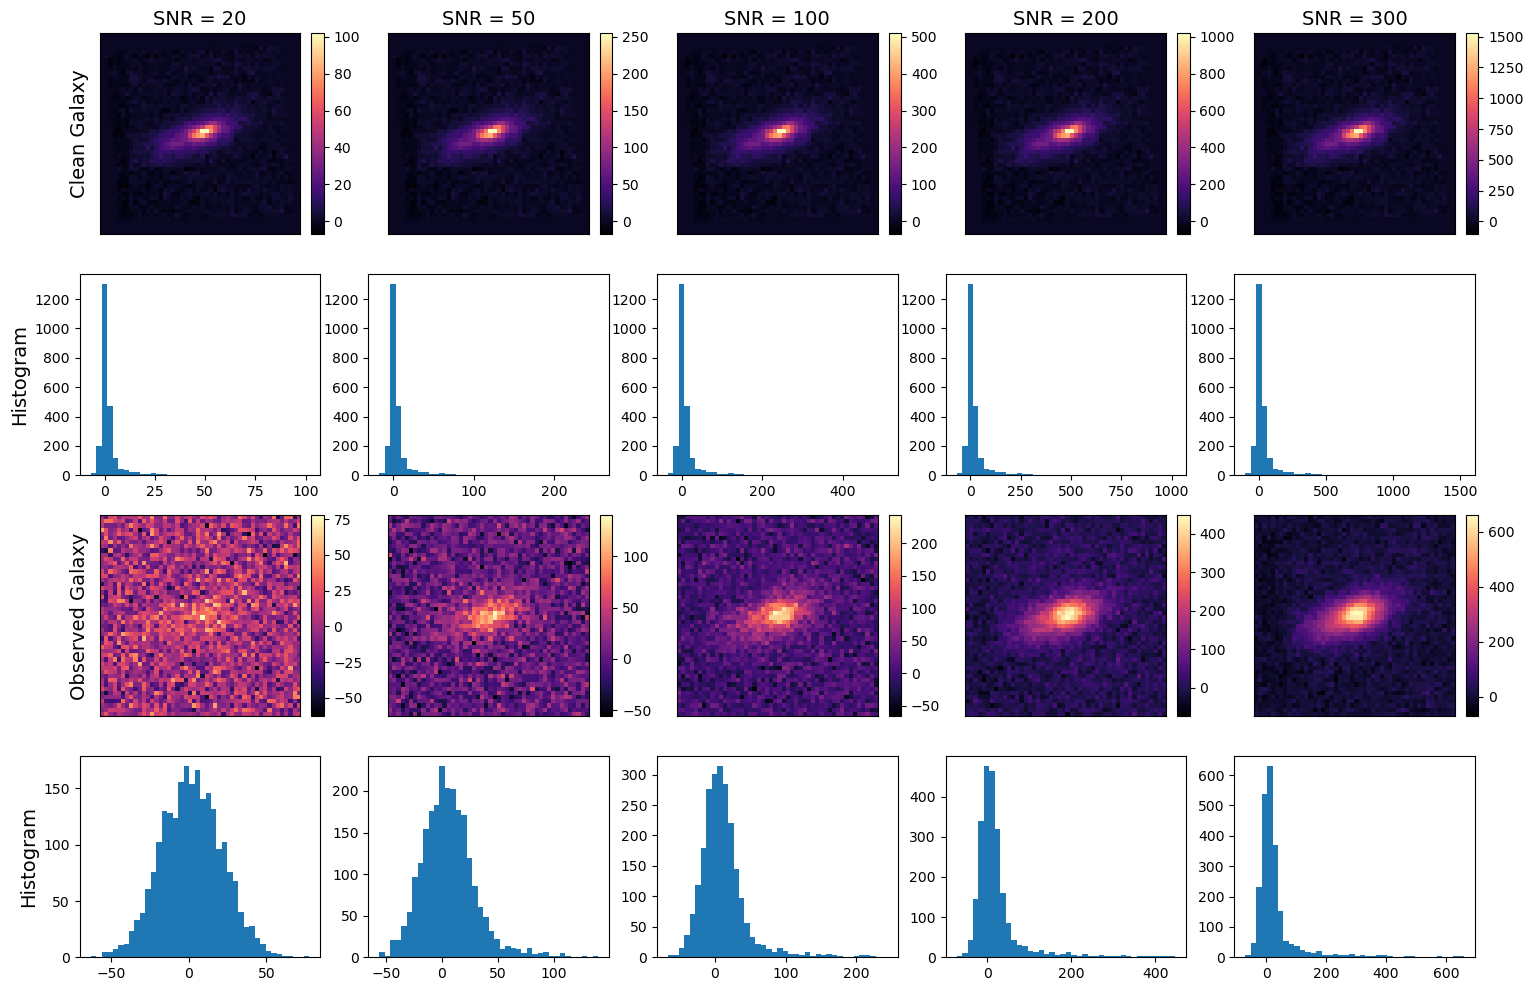

In [19]:
fig = plt.figure(figsize=(18,12))

for idx, (snr, gt ,obs) in enumerate(zip(snr_list, gt_list, obs_list)):
    
    vmax = np.max([obs.max(), gt.max()])
    vmin = np.min([obs.min(), gt.min()])
    norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)
    
    ax1 = plt.subplot(4,len(snr_list),idx+1)
    plt.imshow(gt, cmap=cmap)
    ax1.set_title(f'SNR = {snr}', fontsize=14)
    cax = fig.add_axes([ax1.get_position().x1+6e-3, ax1.get_position().y0, 7e-3, ax1.get_position().height])
    plt.colorbar(cax=cax)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax2 = plt.subplot(4,len(snr_list),idx+1+len(snr_list))
    ax2.hist(gt.ravel(), bins=40)
    # ax2.set_yscale('log')
    
    ax3 = plt.subplot(4,len(snr_list),idx+1+2*len(snr_list))
    plt.imshow(obs, cmap=cmap)
    cax = fig.add_axes([ax3.get_position().x1+6e-3, ax3.get_position().y0, 7e-3, ax3.get_position().height])
    plt.colorbar(cax=cax)
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    ax4 = plt.subplot(4,len(snr_list),idx+1+3*len(snr_list))
    ax4.hist(obs.ravel(), bins=40)
    # ax4.set_yscale('log')
    
    if idx == 0:
        ax1.set_ylabel('Clean Galaxy', fontsize=14)
        ax2.set_ylabel('Histogram', fontsize=14)
        ax3.set_ylabel('Observed Galaxy', fontsize=14)
        ax4.set_ylabel('Histogram', fontsize=14)

### Save Images

In [20]:
torch.save(gt_list[-2], 'gt.pth')
torch.save(psf_image_down, 'psf.pth')
torch.save(obs_list[-2], 'obs.pth')

plt.imsave('../figures/gal_ori_image.jpg', gal_ori_image.array, cmap=cmap)
plt.imsave('../figures/gal_image.jpg', gt_list[-2], cmap=cmap)
plt.imsave('../figures/psf_image.jpg', psf_image[46:-46,46:-46], cmap=cmap)
plt.imsave('../figures/obs.jpg', obs_list[-2], cmap=cmap)

In [21]:
np.save('galaxy.npy', gal_image_down)
np.save('psf.npy', down_sample(psf_image))